# Quantum-classical Mapping

We simulate the dynamics

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s} + \sum_{i} g_{i}(s) \delta_{s^{\prime}, F_{i}[s]} +  \sum_{ij} g_{ij}(s) \delta_{s^{\prime}, F_{ij}[s]}$

with $g_i, g_{ij}$ the flip-probabilities associated with single spin flips and double spin flips, respectively. $F_i[]$ is the flip operator, flipping the spin i of state s. The indices refer to which bits of the spin state will get flipped. $w$ is an extra parameter that allows us to alter the time-scales associated with the spin flips without altering the steady-state distribution. The explicit flip probabilities are given by:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$

The diagonal entries $W(s \mid s)$ are given as $ 1 - \sum_{s'} W(s \mid s')$ Thus the parameters $w$ effectively determine the normalization of the self-transitions and should be chosen large enough such that $W(s \mid s) > 0$.

Using this dynamics we can define a transition matrix. The row entries correspond to the state the system is transitioning from and the collumn entries correspond to the state the system is transitioning towards. The entries of the matrix itself are the corresponding transition probabilities. Each row of the transition matrix should be normalized. Each spin state {-1,1} gets mapped to binary {0,1} where the leftmost bit correspond to the first spin. 

For a 3 spin system, the (horribly) explicit transition matrix would look like:

$$W = \begin{pmatrix}
W(000|000) & g_1(000) & g_2(000) & g_{12}(000) & g_3(000) & g_{13}(000) & g_{23}(000) & 0 \\
g_1(001) & W(001|001) & g_{12}(001) & g_2(001) & g_{13}(001) & g_3(001) & 0 & g_{23}(001) \\
g_2(010) & g_{12}(010) & W(010|010) & g_1(010) & g_{23}(010) & 0 & g_3(010) & g_{13}(010) \\
g_{12}(011) & g_2(011) & g_1(011) & W(011|011) & 0 & g_{23}(011) & g_{13}(011) & g_3(011) \\
g_3(100) & g_{13}(100) & g_{23}(100) & 0 & W(100|100) & g_1(100) & g_2(100) & g_{12}(100) \\
g_{13}(101) & g_3(101) & 0 & g_{23}(101) & g_1(101) & W(101|101) & g_{12}(101) & g_2(101) \\
g_{23}(110) & 0 & g_3(110) & g_{13}(110) & g_2(110) & g_{12}(110) & W(110|110) & g_1(110) \\
0 & g_{23}(111) & g_{13}(111) & g_3(111) & g_{12}(111) & g_2(111) & g_1(111) & W(111|111) \\
\end{pmatrix}$$


Let's try to implement this dynamics:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import minimize

In [3]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx, N):
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # Get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # Convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s):
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # Convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # Set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx, flip_index, N):
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

In [4]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i]
    for j in range(len(s)):
        if i != j:
            sum_term += J[i, j] * s[j]
    return np.exp(-w[i, i] - s[i] * sum_term)

@njit
def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i]
    for k in range(len(s)):
        if k != i:
            sum_term_i += J[i, k] * s[k]

    sum_term_j = h[j]
    for k in range(len(s)):
        if k != j:
            sum_term_j += J[j, k] * s[k]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)

@njit
def choice(probabilities):
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [72]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def compute_transition_matrix(w, h, J):
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        flip_probs = np.zeros((2**N))  # Initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

        # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[s_idx] = no_flip_prob
        transition_matrix[s_idx] = flip_probs

    return transition_matrix

@njit
def spin_flip(s, transition_matrix):
    """
    Flipping algorithm, uses precomputed transition matrix.
    """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    
    if len(flipped_indices) == 0:  # no flip
        pass
    if len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1

    return s

@njit
def simulate_dynamics(W, steps, N):
    """Simulates the dynamics of the system for the given number of steps."""
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, N), dtype=np.int64)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

@njit
def find_min_w(w, h, J, step_size, no_flip_prob):
    """Finds the smallest offset to add to the w parameter such that diagonal elements of W become at least no_flip_prob"""
    min_scalar = 0
    while True:
        # update w with the current scalar value
        new_w = w + np.ones(w.shape) * min_scalar
        
        # calculate the transition matrix
        transition_matrix = compute_transition_matrix(new_w, h, J)
        
        # calculate the self-transition probabilities for each state
        self_probs = np.diag(transition_matrix)

        # check if the self-transition probabilities are all at least no_flip_prob
        if np.all(self_probs >= no_flip_prob):
            break

        # if the condition is not met, increase the scalar value and try again
        min_scalar += step_size

    return new_w


In [73]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------

def plot_combined_dynamics(trajectory, N):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(N):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()


#### **We now effectively can simulate the dynamics given the classical parameters $w$, $J$ and $h$. Let's do some checks:**

[[0.82 0.09 0.01 0.03 0.03 0.02 0.01 0.  ]
 [0.04 0.45 0.03 0.07 0.03 0.12 0.   0.26]
 [0.09 0.22 0.35 0.19 0.06 0.   0.03 0.05]
 [0.01 0.01 0.02 0.75 0.   0.05 0.02 0.14]
 [0.14 0.11 0.05 0.   0.55 0.1  0.01 0.04]
 [0.01 0.03 0.   0.06 0.03 0.73 0.04 0.1 ]
 [0.23 0.   0.11 0.19 0.07 0.19 0.   0.21]
 [0.   0.01 0.   0.02 0.   0.01 0.01 0.94]]
All tests passed!


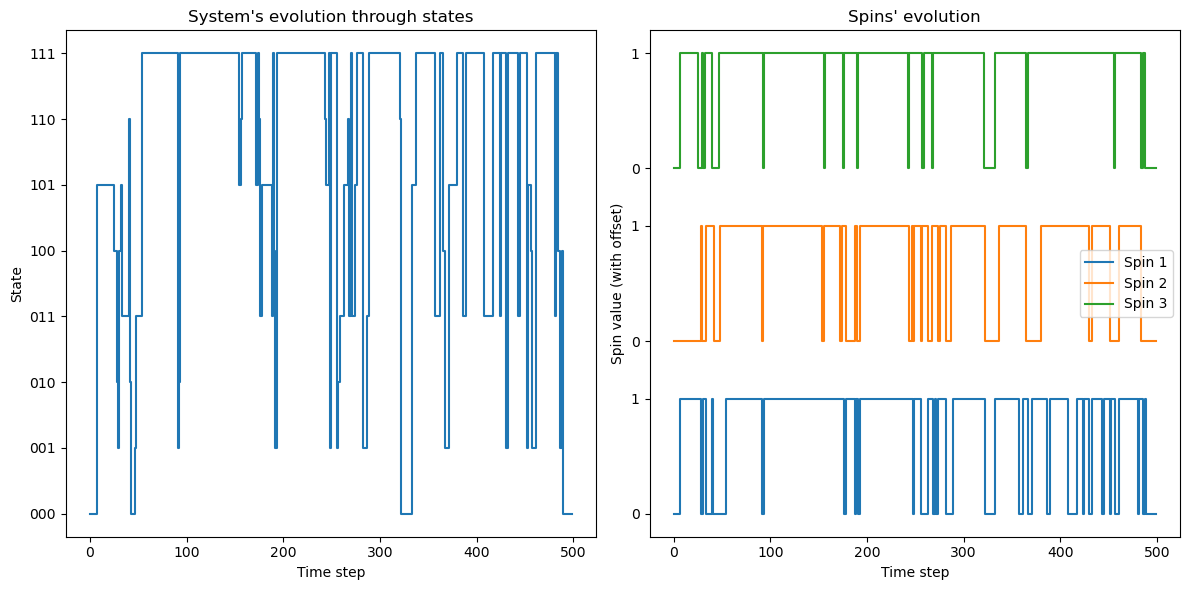

In [94]:
def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

def test_spin_index_conversion(N):
    """Test that the conversion functions between spin states and indices are correct."""
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        assert spin_state_to_index(s) == s_idx, "Conversion failed for index " + str(s_idx)


# Run the tests
N = 3
w = np.random.rand(N, N)
h = np.random.rand(N)
J = np.random.rand(N, N)

#make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

W = compute_transition_matrix(w, h, J)
np.set_printoptions(precision=2 , suppress=True)
test_transition_matrix(W)
test_spin_index_conversion(N)

print("All tests passed!")
trajectory = simulate_dynamics(W, 500, 3)
plot_combined_dynamics(trajectory, N)

Our next goal is to be able to infer the parameters from a time series data of our system. For this we need two separate functions:
1. Going from time series data to an empirical transition matrix
2. Infering the classical parameters from the empirical transition matrix.

 To this end, we can use a classical Boltzmann machine. We can learn the equilibrium Boltzmann distribution of the transition matrix W

In [ ]:
###  INFERENCE FUNCTIONS
#----------------------------------------------------------------------
@njit
def infer_transition_matrix(trajectory):
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]
    n_states = 2**N

    # initialize the transition matrix
    transition_matrix = np.zeros((n_states, n_states))

    # count the transitions from each state to each other state
    for i in range(len(trajectory) - 1):
        # Convert the spin states to indices
        from_idx = spin_state_to_index(trajectory[i])
        to_idx = spin_state_to_index(trajectory[i+1])

        # Update the transition matrix
        transition_matrix[from_idx, to_idx] += 1

    # Normalize each row of the transition matrix
    for i in range(n_states):
        row_sum = transition_matrix[i].sum()
        if row_sum > 0:
            transition_matrix[i] /= row_sum

    return transition_matrix


def negative_log_likelihood(params, trajectory, N):
    """Compute the negative log-likelihood of the observed trajectory given the model parameters."""

    # Unflatten the parameters
    w, h, J = unflatten_parameters(params, N)

    # Calculate the transition matrix with the current values of w, h, and J
    _, transition_matrix = simulate_and_infer_dynamics(w, J, h, steps=1, N=N, fill_missing_entries=True)

    # Compute the negative log-likelihood
    nll = 0
    for i in range(trajectory.shape[0] - 1):
        s = trajectory[i]
        s_next = trajectory[i + 1]
        s_idx = spin_state_to_index(s)
        s_next_idx = spin_state_to_index(s_next)

        # Probability of transitioning from s to s_next
        prob = transition_matrix[s_idx, s_next_idx]

        if prob > 0:
            nll -= np.log(prob)

    return nll

def infer_parameters(trajectory, N, initial_params=None):
    """Infer the parameter matrices w, h, and J by minimizing the likelihood from a time series data of the states the system went through."""

    if initial_params is None:
        # Create initial guess for the parameters
        w_init = np.random.rand(N, N)
        h_init = np.random.rand(N)
        J_init = np.random.rand(N, N)

        initial_params = flatten_parameters(w_init, h_init, J_init)

    # Minimize the negative log-likelihood using the BFGS algorithm
    result = minimize(negative_log_likelihood, initial_params, args=(trajectory,N), method='BFGS')

    # Unflatten the optimized parameters back into matrices
    w_opt, h_opt, J_opt = unflatten_parameters(result.x, N)

    return w_opt, h_opt, J_opt

def boltzmann_distribution(J, h):
    N = len(h)
    all_states = np.array([index_to_spin_state(s_idx, N) for s_idx in range(2**N)])
    energies = np.array([energy(state, J, h) for state in all_states])
    probabilities = np.exp(-energies)
    Z = np.sum(probabilities)
    return probabilities / Z


def energy(s, J, h):
    """
    Compute the energy of the system in a particular spin state.
    """
    s = s.astype(np.float64)                              # convert the spin configuratio to float64 for numba
    pairwise_energy = np.dot(s, np.dot(J, s))
    local_field_energy = h * s                            # simple multiplication for scalar-array operation
    return -pairwise_energy - np.sum(local_field_energy)  # sum over local field energy


In [ ]:
###  2-QUBIT QBM FUNCTIONS
#----------------------------------------------------------------------
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex64)

    interactions = np.zeros((4, 4, 4, 4), dtype=np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k, kprime] = np.kron(pau[k], pau[kprime])
    return interactions

@njit
def hamiltonian2spins(J,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    h = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            h += J[k,kprime] * interactions[k,kprime]
    return h

@njit
def rho_model(w,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    h      = hamiltonian2spins(w,interactions)        #  get hamiltonian matrix
    rho    = expmat(h)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

@njit
def observables(rho, interactions):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros((4,4))
    for k in range(4):
        for kprime in range(4):
            obs[k,kprime] = np.real(np.trace(rho@interactions[k,kprime]))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def generate_random_parameter_matrix(seed):
    np.random.seed(seed)              # set random seed for reproducibility
    w = np.random.randn(4, 4)         # get normal distributed weights
    w[0, 0] = 0
    return w

def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

@njit
def quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, w_eta=None, eta=None):
    """
    Train the model to fit the target distribution eta
    """
    if w_eta is not None:
        eta = rho_model(w_eta, interactions)               # compute density matrix using ED if w_eta is provide
    obs_clamped  = observables(eta, interactions)          # get QM clamped statistics  
    
    w    = generate_random_parameter_matrix(random_seed)  # initialize random parameters
    rho  = rho_model(w, interactions)                      # compute density matrix using ED
    obs  = observables(rho, interactions)                  # get QM statistics  
    
    it = 0                                                 #  initialize gradient ascent loop
    diff = np.max(np.abs(obs-obs_clamped))
    Wmax_list = np.zeros(maxiter)                          #  initialize values to store
    KL_list   = np.zeros(maxiter)
    
    
    while (diff > tol and it < maxiter): 
        rho  = rho_model(w, interactions)                   # compute density matrix using ED
        obs  = observables(rho, interactions)               # get QM statistics  
        w              += lr * (obs_clamped -  obs)         #  update parameters
        
        diff = np.max(np.abs(obs - obs_clamped))            #  evaluate differences in clamped and model statistics   
        if w_eta is not None:
            Wmax = np.max(np.abs(w-w_eta))
            Wmax_list[it] = Wmax                                #  store values
        
        KL_list[it]   = KL_divergence(eta,rho) 
        it += 1 
    return w, rho, KL_list, Wmax_list, it

In [ ]:
### QBM <-> ISING DYNAMICS FUNCTIONS
#----------------------------------------------------------------------
# @njit
def transition_matrix_to_density_matrix(W):
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex64) #make it complex    

    return rho

# @njit
def density_matrix_to_transition_matrix(rho):
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1, keepdims=True)
    W /= W_row_sum
    return W

def check_ergodicity(rho, K=10):
    """
    Check if the density matrix rho is ergodic by iteratively squaring
    the matrix up to K times and checking for non-zero entries.
    """
    for _ in range(K):
        if np.all(rho > 0):
            return True
        
        # quadratic of the density matrix
        rho = rho @ rho

    # if after K iterations, there are still zero components, the matrix is not ergodic.
    return False

def check_single_flip_ergodicity(rho, W, N):
    """
    Check if the components of the density matrix rho that correspond to 
    the transitions of the transition matrix W involving single spin flips are non-zero.
    """
    n_states = 2 ** N

    for from_idx in range(n_states):
        for i in range(N):
            # calculate the index of the state with the ith spin flipped
            to_idx = from_idx ^ (1 << i)

            # if the transition corresponds to a single spin flip and the component in rho is zero, return False
            if W[from_idx, to_idx] > 0 and rho[from_idx, to_idx] == 0:
                return False

    # if all components corresponding to single spin flips are non-zero, return True
    return True

## PPT slide recreation

- Homogenous systems first [all the same]
- biases <-> sigma z
- Make a way to systematically review the change in parameters. Plots of the change in parameters versus the change in an other

infer_parameters()  [Combo of BM ]
forward_mapping()
inverse_mapping()
forward_mapping_plot
inverse_mapping_plot


Forward mapping

In [ ]:
N = 2
w = np.array([[12.,12.],
              [12.,12.]])
J = np.array([[0,0],
              [0,0,]])
h = np.array([0,  0])


steps = 1500

# #min w parameters
# step_size = 0.01
# min_no_flip_prob = 0           #
# min_w = find_min_w(w, h, J, N, step_size, min_no_flip_prob)

#QBM parameters
lr = 0.6
maxiter = 2**20
tol = 1e-6
random_seed = 777

#GET W 
trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)

#W TO eta
eta = transition_matrix_to_density_matrix(W)

#RHO TO QM HAMILTONIAN
interactions     = generate_interaction_matrices()    
w_qm, rho, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)

error_message, error_matrix = check_density_matrices(eta, rho)
if error_message is not None:
    print(error_message)
    
np.set_printoptions(precision=8, suppress=True)
print(f"Classical parameters: \n w: \n {w} \nJ: \n {J} \n h: \n {h}")
print(f"QM parameters: \n {w_qm}")

In [ ]:
N = 2
w = np.array([[1.2,2.0],
              [2.0,1.2]])
J = np.array([[0,2],
              [2,0,]])
h = np.array([0,  0])


steps = 1500

# #min w parameters
# step_size = 0.01
# min_no_flip_prob = 0           #
# min_w = find_min_w(w, h, J, N, step_size, min_no_flip_prob)

#QBM parameters
lr = 0.2
maxiter = 2**20
tol = 1e-6
random_seed = 777

#GET W 
trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)

#W TO eta
eta = transition_matrix_to_density_matrix(W)

#RHO TO QM HAMILTONIAN
interactions     = generate_interaction_matrices()    
w_qm, _, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)
np.set_printoptions(precision=2, suppress=True)
print(f"Classical parameters: \n w: \n {w} \nJ: \n {J} \n h: \n {h}")
print(f"QM parameters: \n {w_qm}")

### Let's build a pipeline for this process

In [ ]:
def param_sweep_and_plot(initial_value, final_value, step_size, param_index, classical_params, other_params):
    """
    initial_value: initial value of the parameter
    final_value: final value of the parameter
    step_size: size of each step between initial_value and final_value
    param_index: a tuple indicating the location of the parameter to change in classical_params (e.g., (0, 1) to change w[0,1])
    classical_params: a list containing the [w, J, h] matrices
    other_params: a dictionary containing other parameters for quantum_boltzmann_machine function
    """
    # Unpack classical parameters
    w, J, h = classical_params
    classical_param_names = ['w', 'J', 'h']
    
    # Unpack other parameters
    lr = other_params['lr']
    maxiter = other_params['maxiter']
    tol = other_params['tol']
    random_seed = other_params['random_seed']

    # Prepare for parameter sweep
    param_values = np.arange(initial_value, final_value, step_size)
    qm_params = []

    # Sweep parameter values
    for val in param_values:
        # Change the parameter
        if param_index[0] < len(w):
            classical_params[param_index[0]][param_index[1], param_index[2]] = val
        elif param_index[0] == len(w):
            h[param_index[1]] = val
        else:
            raise ValueError("Invalid param_index.")
        
        # Re-run the pipeline with the new parameter value
        trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)
        eta = transition_matrix_to_density_matrix(W)
        interactions = generate_interaction_matrices()    
        w_qm, _, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)
        
        # Store the quantum parameters
        qm_params.append(w_qm)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(4):
        for j in range(4):
            plt.plot(param_values, [params[i, j] for params in qm_params], label=f"w_qm[{i},{j}]")
    plt.xlabel(f"Classical parameter {classical_param_names[param_index[0]]}[{param_index[1]},{param_index[2]}]")
    plt.ylabel("Quantum parameters w_qm")
    plt.legend()
    plt.show()

In [ ]:
classical_params = [w, J, h]
other_params = {'lr': 0.2, 'maxiter': 2**20, 'tol': 1e-6, 'random_seed': 777}
param_sweep_and_plot(1.0, 2.0, 0.1, (0, 0, 1), classical_params, other_params)

## Inverse Route Pipeline

In [ ]:
###  SIMULATION HELPER FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N):
    '''Generates all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_contiguous = np.ascontiguousarray(config)        # use contiguos array for faster numba 
    energy = -np.dot(config_contiguous.T, np.dot(J, config_contiguous)) / 2 - np.dot(h, config_contiguous)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(beta, J, h, Ci, CiCj):
    '''Computes the log-likelihood of the model'''
    energies = -np.dot(J, CiCj) - np.dot(h, Ci)          # calculate the energies using the free statistics of an iteration
    boltzmann_probs = np.exp(-beta * energies)           # calculate the Boltzmann probabilities
    Z = np.sum(np.exp(-energies))                        # calculate the partition function
    log_likelihood = np.sum(np.log(boltzmann_probs / Z)) # calculate the log-likelihood
    return log_likelihood

@njit
def ising_solve_exact_simplified(N, J, h, configs):    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this 
                                                      #  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj


# @njit
def classical_boltzmann_machine(p, N, configs, maxiter, learning_rate):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''

    #NEED TO ADD LIKELIHOOD AND TOLERANCE OF CONVERGENCE OF LIKELIHOOD?
    beta = 1.0
    J_assym = 2.0 * np.random.random((N, N)) - 1.0  # random values between -1 and 1
    J = (J_assym+ J_assym.T)/2                           #  symmetrize the random matrix 
    h = 2.0 * np.random.random(N) - 1.0  # random values between -1 and 1

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    Li_values = []  #store values to plot
    
    while (it < maxiter):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 
            
        h     = h + learning_rate * (Ci_clamp   - Ci_free)               #  update weight matrix based on statistics  
        J     = J + learning_rate * (CiCj_clamp - CiCj_free)

        # Make sure that J is symmetric after each update
        J = (J + J.T) / 2

        Li    = log_likelihood(beta, J, h, Ci_free, CiCj_free)
        Li_values.append(Li)
        
    return J, h, it, Li_values


def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

def tweak_w_value(W, w, h, J, N, from_idx ,to_idx, w_bottom = -100, w_top = 100, tolerance=1e-6, max_iterations=2000):
    '''Adjusts the value of w until the discrepancy with the target value is within the specified tolerance.'''
    W_clamped = W[from_idx,to_idx]
    w_low = w_bottom
    w_high = w_top
    for _ in range(max_iterations):
        w_mid = (w_low + w_high) / 2.0
        s = index_to_spin_state(from_idx, N)
        flipped_indices = bits_flipped_indices(from_idx, to_idx, N)

        if len(flipped_indices) == 1:  # single flip
            i = flipped_indices[0]
            w[i,i] = w_mid
            W_free = g_single(i, s, w, h, J) 
        elif len(flipped_indices) == 2: # double flip
            i, j = flipped_indices
            w[i,j] = w_mid
            w[j,i] = w_mid
            W_free = g_double(i,j,s,w,h,J)
        else:  #no flip
            W_free = 1 #arbitrary value above tolerance

        diff = W_free - W_clamped
        if abs(diff) < tolerance:
            return w_mid, W_free
        elif diff < 0:
            w_high = w_mid
        else:
            w_low = w_mid
    raise ValueError(f"Failed to find suitable w value within {max_iterations} iterations.")


def infer_parameters(W, N, configs, lr_BM, maxiter_BM):
    """
    Infer the parameters J, h, and w from a transition matrix W.
    
    W: transition matrix
    N: number of spins
    """
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 
    
    # infer J and h from p using a classical Boltzmann machine
    J, h, _ , _ = classical_boltzmann_machine(p, N, configs, maxiter_BM, lr_BM)
    
    # Initialize w with zeros
    w = np.zeros((N, N))
    
    # calculate the w values exactly
    for i in range(2**N):
        for j in range(2**N):
            s = index_to_spin_state(i, N)
            flipped_indices = bits_flipped_indices(i, j, N)
            if len(flipped_indices) == 1:  # single flip
                k = flipped_indices[0]
                sum_term = h[k]
                for l in range(len(s)):
                    if k != l:
                        sum_term += J[k, l] * s[l]
                w[k, k] = -np.log(W[i,i]) - s[k] * sum_term
            elif len(flipped_indices) == 2: # double flip
                    sum_term_k = h[k]
                    for o in range(len(s)):
                        if o != k:
                            sum_term_k += J[k, o] * s[o]
                    sum_term_l = h[l]
                    for o in range(len(s)):
                        if o != l:
                            sum_term_l += J[l, o] * s[o]
                    w[k, l] = -np.log(W[i,j]) - J[k, l] * s[k] * s[l] - s[k] * sum_term_k - s[l] * sum_term_l
            elif len(flipped_indices) == 0:  # not allowed // no flip
                pass

    return J, h, w

In [ ]:
# QM HAMILTONIAN PARAMETERS
wx1x2 = 2
wy1y2 = 5
wz1z2 = 0
hx1   = 1
hx2   = 1
hy1   = 4
hy2   = 0
hz1   = 0
hz2   = 0

w_eta            = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)  
N = 2

#QBM parameters
lr_QBM      = 0.2
maxiter_QBM = 2**20
tol_QBM     = 1e-6
random_seed = 777

#BM parameters
lr_BM      = 0.2
maxiter_BM = 2**20
tol_BM     = 1e-6
steps      = 1500

#QUANTUM HAMILTONIAN TO RHO
interactions     = generate_interaction_matrices()     
_, rho, _, _, _ = quantum_boltzmann_machine(interactions, lr_QBM, maxiter_QBM, tol_QBM, random_seed, w_eta = w_eta)

#RHO TO W
W = density_matrix_to_transition_matrix(rho)
if not check_ergodicity(rho, K=10):
    print('error')

np.set_printoptions(precision=2, suppress=True)
# SIMULATE SYSTEM & INFER PARAMETERS
trajectory = simulate_dynamics(W, steps, N)

configs = all_possible_configs(N)
w_opt, h_opt, J_opt = infer_parameters(W, N, configs, lr_BM, maxiter_BM)

print(f"Input QM parameters: \n {w_eta}")
print(f"Inferred w: \n {w_opt}")
print(f"Inferred h: \n {h_opt}")
print(f"Inferred J: \n {J_opt}")

print(f'W to model: \n{W}')
trajectory, W_params = simulate_and_infer_dynamics(w_opt,J_opt,h_opt, 15, 2)
print(f'W from inferred parameters: \n {W_params}')